i'm following this: https://www.kaggle.com/davids1992/speech-representation-and-data-exploration
and this:
https://www.tensorflow.org/versions/master/tutorials/audio_recognition#preparation

### Example: From audio to spectrogram

In [3]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
# import seaborn as sns
import IPython.display as ipd
# import librosa.display

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
# import pandas as pd

%matplotlib inline

In [92]:
# read some file...
path = '/gpfs/scratch/userexternal/ffranchi/speech/'
filename = 'bird/8012c69d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(path) + filename)

In [38]:
print(sample_rate, "values")

16000 values


In [53]:
print("from", min(samples),"to", max(samples))

from -17015 to 14174


In [1]:
# define the log because of how humans hear sounds...
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [51]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)
print(freqs)
print(times)

[   0.   50.  100.  150.  200.  250.  300.  350.  400.  450.  500.  550.
  600.  650.  700.  750.  800.  850.  900.  950. 1000. 1050. 1100. 1150.
 1200. 1250. 1300. 1350. 1400. 1450. 1500. 1550. 1600. 1650. 1700. 1750.
 1800. 1850. 1900. 1950. 2000. 2050. 2100. 2150. 2200. 2250. 2300. 2350.
 2400. 2450. 2500. 2550. 2600. 2650. 2700. 2750. 2800. 2850. 2900. 2950.
 3000. 3050. 3100. 3150. 3200. 3250. 3300. 3350. 3400. 3450. 3500. 3550.
 3600. 3650. 3700. 3750. 3800. 3850. 3900. 3950. 4000. 4050. 4100. 4150.
 4200. 4250. 4300. 4350. 4400. 4450. 4500. 4550. 4600. 4650. 4700. 4750.
 4800. 4850. 4900. 4950. 5000. 5050. 5100. 5150. 5200. 5250. 5300. 5350.
 5400. 5450. 5500. 5550. 5600. 5650. 5700. 5750. 5800. 5850. 5900. 5950.
 6000. 6050. 6100. 6150. 6200. 6250. 6300. 6350. 6400. 6450. 6500. 6550.
 6600. 6650. 6700. 6750. 6800. 6850. 6900. 6950. 7000. 7050. 7100. 7150.
 7200. 7250. 7300. 7350. 7400. 7450. 7500. 7550. 7600. 7650. 7700. 7750.
 7800. 7850. 7900. 7950. 8000.]
[0.01 0.02 0.03 0.0

Text(0.5,0,'Seconds')

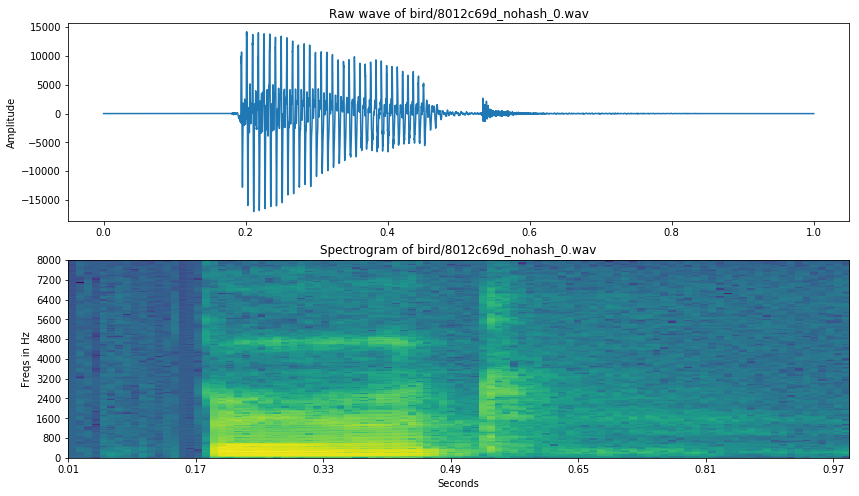

In [54]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

### Silence removal

In [56]:
ipd.Audio(samples, rate=sample_rate)

In [89]:
samples_cut = samples[2800:13000]
ipd.Audio(samples_cut, rate=sample_rate)

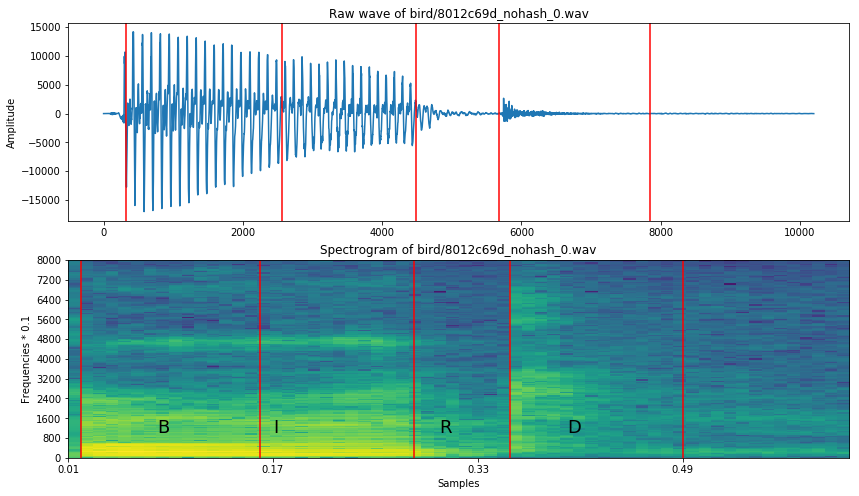

In [90]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])

ax2.text(0.08, 1000, 'B', fontsize=18)
ax2.text(0.17, 1000, 'I', fontsize=18)
ax2.text(0.30, 1000, 'R', fontsize=18)
ax2.text(0.40, 1000, 'D', fontsize=18)

xcoords = [0.02, 0.16, 0.28, 0.355, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

### Dimensionality reduction

In [92]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [93]:
# filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [96]:
ipd.Audio(samples, rate=sample_rate)


In [97]:
ipd.Audio(resampled, rate=new_sample_rate)

## Light-weight CNN
this is interesting: https://www.kaggle.com/alphasis/light-weight-cnn-lb-0-74

## what does librosa do?

librosa:
https://librosa.github.io/librosa/tutorial.html

In [5]:
import librosa

16000


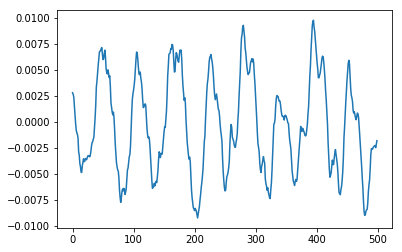

In [6]:
file_path = '../data/speech/right/97f4c236_nohash_2.wav'
wave, sr = librosa.load(file_path, mono=True, sr=None)

plt.plot(wave[:500])
print(sr)

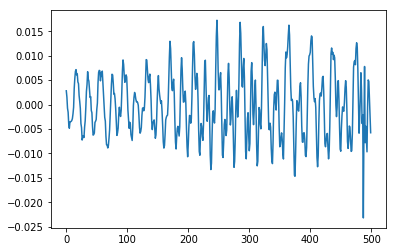

In [11]:
wave_mod = wave[::3]
plt.plot(wave_mod[:500])

In [15]:
mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=32)
mfcc.shape

(32, 32)

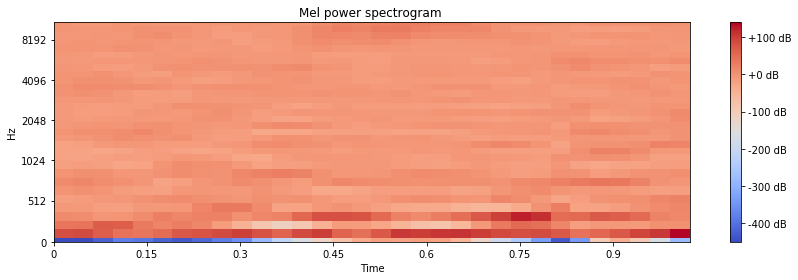

In [16]:
import librosa.display 

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, sr=16000, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [12]:
mfcc = librosa.feature.mfcc(wave_mod, sr=16000, n_mfcc=11)
mfcc.shape

(11, 11)

## How to use preprocess.py

reference: https://blog.manash.me/building-a-dead-simple-word-recognition-engine-using-convnet-in-keras-25e72c19c12b

In [1]:
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
%run -i 'preprocess.py'

Using TensorFlow backend.


In [125]:
path = "../data/speech/"
out_dir = 'arrays/'

In [87]:
labels, _, _ = get_labels()
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [126]:
# this creates the array files of the spectrograms
save_data_to_array(path)

In [58]:
# number of classes
len(labels)

35

In [102]:
# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 20
feature_dim_2 = 11
channel = 1
epochs = 10
batch_size = 100
verbose = 1
num_classes = len(labels) # 35 without background noise

In [103]:
# Reshaping to perform 2D convolution, which is spatial convolution over images
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [104]:
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

63497 63497
42332 42332


In [105]:
# input shape
X_train[0].shape

(20, 11, 1)

In [5]:
!nvidia-smi

Tue Jul 17 10:04:19 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.39                 Driver Version: 375.39                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40m          On   | 0000:0B:00.0     Off |                    0 |
| N/A   27C    P0    61W / 235W |     81MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40m          On   | 0000:86:00.0     Off |                    0 |
| N/A   26C    P0    61W / 235W |     81MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### First try with a given model
https://blog.manash.me/building-a-dead-simple-word-recognition-engine-using-convnet-in-keras-25e72c19c12b

In [130]:
%run -i 'basic_CNN.py'

In [25]:
model = get_model()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 12699 samples, validate on 8466 samples
Epoch 1/10
12699/12699 [==============================] - 7s 570us/step - loss: 3.6228 - acc: 0.0503 - val_loss: 3.3628 - val_acc: 0.0872
Epoch 2/10
12699/12699 [==============================] - 5s 389us/step - loss: 3.2601 - acc: 0.1004 - val_loss: 2.9117 - val_acc: 0.2042
Epoch 3/10
12699/12699 [==============================] - 5s 396us/step - loss: 2.9200 - acc: 0.1828 - val_loss: 2.5439 - val_acc: 0.2990
Epoch 4/10
12699/12699 [==============================] - 5s 398us/step - loss: 2.5430 - acc: 0.2703 - val_loss: 2.1140 - val_acc: 0.4126
Epoch 5/10
12699/12699 [==============================] - 5s 391us/step - loss: 2.2330 - acc: 0.3531 - val_loss: 1.7384 - val_acc: 0.5150
Epoch 6/10
12699/12699 [==============================] - 5s 390us/step - loss: 1.9759 - acc: 0.4229 - val_loss: 1.6250 - val_acc: 0.5475
Epoch 7/10
12699/12699 [==============================] - 5s 391us/step - loss: 1.7661 - acc: 0.4857 - val_loss: 1.4185 - v

### Make predictions from that model

In [67]:
# Predicts one sample given its path
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][np.argmax(model.predict(sample_reshaped))]

In [68]:
# prediction example

print(predict(path + 'backward/45692b02_nohash_0.wav', model=model))

bird


In [74]:
# it can be also used on lists
path = '../data/speech/'

samples_list = []
samples_list.append(os.path.join(path, 'backward', os.listdir(path+ 'backward')[1]))
samples_list.append(os.path.join(path, 'zero',os.listdir(path+ 'zero')[1]))
samples_list.append(os.path.join(path, 'eight',os.listdir(path+ 'eight')[1]))

samples_list

['../data/speech/backward/45692b02_nohash_0.wav',
 '../data/speech/zero/c6a23ff5_nohash_0.wav',
 '../data/speech/eight/b91b718c_nohash_0.wav']

In [71]:
for sample_name in samples_list:
    print(predict(sample_name, model=model))

bird
six
eight


In [86]:
# predict many samples (given the samples themselves)
def predict_samples(test_samples, model):
    predictions = []
    for sample in test_samples:
        sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
        predictions.append(get_labels()[0][
                np.argmax(model.predict(sample_reshaped))])
    return predictions

In [90]:
predictions = predict_samples(X_test, model)

In [96]:
for n in range(1,10):
    print(predictions[n],y_test[n])

six 25.0
one 21.0
tree 12.0
tree 12.0
marvin 21.0
nine 14.0
right 22.0
tree 12.0
one 21.0


In [131]:
import pandas as pd

df = pd.read_csv(path+'testing_list.txt', delimiter=',')
testing_list = df.iloc[:,0]

print(testing_list[:5])

testing_list = [os.path.join(path,filename) for filename in testing_list]

# subset, just trying
testing_list = testing_list[:10]

0    right/97f4c236_nohash_2.wav
1    right/f2e59fea_nohash_3.wav
2    right/fdb5155e_nohash_2.wav
3    right/dc75148d_nohash_0.wav
4    right/3f170018_nohash_0.wav
Name: right/bb05582b_nohash_3.wav, dtype: object


In [137]:
testing_list[:10]

['../data/speech/right/97f4c236_nohash_2.wav',
 '../data/speech/right/f2e59fea_nohash_3.wav',
 '../data/speech/right/fdb5155e_nohash_2.wav',
 '../data/speech/right/dc75148d_nohash_0.wav',
 '../data/speech/right/3f170018_nohash_0.wav',
 '../data/speech/right/18f8afd5_nohash_3.wav',
 '../data/speech/right/e1469561_nohash_1.wav',
 '../data/speech/right/5c8af87a_nohash_0.wav',
 '../data/speech/right/aa48c94a_nohash_0.wav',
 '../data/speech/right/837a0f64_nohash_1.wav']

In [135]:
def predict_list(testing_list, model):
    predictions = []
    for filename in testing_list:
        predictions.append(predict(filename, model=model))
    return(predictions)

In [138]:
predict_list(testing_list, model)

['happy',
 'right',
 'right',
 'right',
 'right',
 'right',
 'seven',
 'right',
 'three',
 'right']